In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt #Plotting diagrams
import seaborn as sns #Plotting diagrams
%matplotlib inline 
#Te quitas errores al usar plt o sns

In [ ]:
dtrain = pd.read_csv("/kaggle/input/titanic/train.csv") #This is the training set
dtest = pd.read_csv("/kaggle/input/titanic/test.csv") #This is the test set
dgender = pd.read_csv("/kaggle/input/titanic/gender_submission.csv") #THIS IS THE OUTPUTS OF THE TEST SET


In [ ]:
Pclass = dtrain["Pclass"] #Passenger Class
Sex = dtrain["Sex"]
Age = dtrain["Age"]
SibSp = dtrain["SibSp"] #Number of siblings / spouses aboard the Titanic
Parch = dtrain["Parch"] #Number of parents / children aboard the Titanic	
Cabin = dtrain["Cabin"] 
Embarked = dtrain["Embarked"] #Port of embarkment


In [ ]:
dtrain['train_test'] = 1 #ADDS column 'train_test' with 1's.
dtest['train_test'] = 0 #ADDS column 'train_test' with 0's.
dtest['Survived'] = np.NaN #ADDS column 'Survived' with NaN object.
all_data = pd.concat([dtrain,dtest]) #Joins both dataframes 
print(all_data)

 **Let's first analyse the data**

In [ ]:
all_data.info()

In [ ]:
all_data.describe()
# to better understand the numeric data, 
# we want to use the .describe() method. This gives us 
# an understanding of the central tendencies of the data

In [ ]:
# look at numeric and categorical values separately 
df_num = all_data[['Age','SibSp','Parch','Fare']]
df_cat = all_data[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

# We now analyse the categorical features

In [ ]:
print("PRIMERO VEMOS ESTO ")
print(df_cat['Pclass'].value_counts()) #Esto es un Series object

#This is just to show what 
# the code bellow is doing
print( "AHORA ESTO:")
print(df_cat['Pclass'].value_counts().index) #Esto es casi como un array

In [ ]:
for i in df_cat.columns: #Choosing only the categorical data
    df_cat[i].value_counts().plot(kind='bar',rot =0)
    plt.title(i)
    plt.show()


Note there is loads of Cabin and Ticket features, so we might want to do some feature engineering

Maybe Cabin's closer to each other tended to either survive or not.

Person's title relate to survival rates??

In [ ]:
#Vamos a ver que tipo de tickets hay
print(all_data['Ticket'].value_counts())

There's more tickets than ticket numbers so maybe tickets booked together have the same number. Meaning we can tell if individuals were travelling acompanied or not (we can also tell this from Parch and SibSp, but this also includes non-family members). 

In [ ]:
all_data['Ticket_group_size'] = all_data.groupby('Ticket')['Ticket'].transform('count')
print(all_data['Ticket_group_size'])

Above we can see the number of persons that had the same ticket for each individual.

In [ ]:
#Vamos a ver que tipo de cabins hay
print(all_data['Cabin'].head(5))
print(all_data['Cabin'].head(-885))
print(all_data['Cabin'].value_counts().head(-120))

In [ ]:
#Now im going to check if even or odd cabins were more prone to surviving
def check_parity_cabins(x):
    if pd.isna(x)==True: #nan para los que no se sabe numero
        return np.nan
    elif len(x.split(' '))>1: #Algunos tienen varias cabinas(asi que miramos su primera)
        y = x.split(' ')[0][1:]
        if y.isnumeric()==False: #Miramos la segunda en caso que la primera no tenga numero
            z = x.split(' ')[1][1:]
            if int(z)%2==0:
                return '1even'
            else:
                return '1odd'
        elif int(y)%2==0:
            return '1even'
        else:
            return '1odd'
    elif x[1:].isnumeric()== True and int(x[1:])%2 == 0:
        return '1even'
    elif x.split(' ')[0][1:].isnumeric()==False:
        return np.nan
    else:
        return '1odd'
        
all_data['Cabin_last_digit'] = all_data.apply(lambda x: check_parity_cabins(x.Cabin) if x.Pclass == 1 else np.nan, axis =1)
print(pd.pivot_table(all_data, index = 'Survived', columns = 'Cabin_last_digit', values = 'Ticket' ,aggfunc ='count'))
print()

Even numbered cabins had less survival rate.

Let's now see the cabin letters

In [ ]:
#creates categories based on the cabin letter (n stands for null)
#in this case we will treat null values like it's own category

all_data['cabin_letter'] = all_data.Cabin.apply(lambda x: "letter " + str(x)[0])


In [ ]:
#comparing surivial rate by cabin
print(all_data.cabin_letter.value_counts())
pd.pivot_table(all_data,index='Survived',columns='cabin_letter', values = 'Ticket', aggfunc='count')

Maybe B, D y E have higher survival rates. Checking a map of the titanic, there was no cabin T, hence I am going to drop it. I am also dropping letter n, since that means we don't know the letter. I drop this values later.

Let's also see the correlation values between the cabin letter and the passenger class, because maybe one depends on the other. I do this after one hot featuring because I use the fact that I have splitted the Cabin letter feature into the corresponding letters.

In [ ]:
pd.pivot_table(all_data,index='Pclass',columns='cabin_letter', values = 'Ticket', aggfunc='count')

As we can see we don't have much info on the cabin on the 2nd and 3rd class passengers, hence for them the model can't learn much about the cabin. Therefore I am going to just use the cabin letter of the first class passengers. I am going to divide the first class passenger feature into 6 features: 1letter_A, 1letter_B, 1letter_C, 1letter_D, 1letter_E and 1letter_n.

In [ ]:
all_data['1letter_A'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter A' and x.Pclass==1 else 0, axis =1)
all_data['1letter_B'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter B' and x.Pclass==1 else 0, axis =1)
all_data['1letter_C'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter C' and x.Pclass==1 else 0, axis =1)
all_data['1letter_D'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter D' and x.Pclass==1 else 0, axis =1)
all_data['1letter_E'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter E' and x.Pclass==1 else 0, axis =1)
all_data['1letter_n'] = all_data.apply(lambda x: 1 if x.cabin_letter=='letter n' and x.Pclass==1 else 0, axis =1)

In [ ]:
#Selecting the title a person had 
all_data.Name.head(50)
all_data['name_title'] = all_data.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
print(all_data['name_title'].value_counts())
#mr., ms., master. etc

Looks like Mr, Miss, Mrs and Master are the most popular. 

Although Mlle is French for Miss (unmarried) and Mme is French for Mrs. Hence we are going to group these. Ms is also another way of saying Miss.

In order to reduce time computation due to too many features we are also going to group the least common features into an LeastCommontitles group.


In [ ]:
all_data[all_data['name_title']=='Miss']['Age'].dropna().hist(alpha=0.5, bins=20, label='Miss')
all_data[all_data['name_title']=='Master']['Age'].dropna().hist(alpha=0.5, bins=4, label='Master')

plt.title('Distribution of Age for Miss. and Master.')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

As we can see from the plot above, Master is used for men under the age of 18.


In [ ]:
# Recategorize uncommon titles that fit into "Miss." and "Mrs."
all_data.loc[all_data['name_title'].isin(['Ms', 'Mlle']), 'name_title'] = 'Miss'
all_data.loc[all_data['name_title'].isin(['Mme']), 'name_title'] = 'Mrs'

# Create new title 'Uncommon'
LeastCommontitles = ['Major', 'Lady', 'Sir', 'Don', 'Capt', 'Countess', 'Jonkheer', 'Dona', 'Dr', 'Rev', 'Col', 'the Countess']
all_data.loc[all_data['name_title'].isin(LeastCommontitles), 'name_title'] = 'Uncommon'

# Display count of each title 
display(all_data['name_title'].value_counts())

In [ ]:
# Comparing survival and each of these categorical variables 
print(pd.pivot_table(all_data, index = 'Survived', columns = 'Pclass', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(all_data, index = 'Survived', columns = 'Sex', values = 'Ticket' ,aggfunc ='count'))
print()
print(pd.pivot_table(all_data, index = 'Survived', columns = 'Embarked', values = 'Ticket' ,aggfunc ='count'))

**Now I am going to perform ONE HOT ENCODING on categorical data**

In [ ]:
print(all_data.columns)

In [ ]:
all_data.Pclass = all_data.Pclass.astype(str) #The data in passenger class is numeric but I want it in object type do that hstack works

**We are going to be using all the data as one hot, so we do all the above to all_data (not just dtrain)**

In [ ]:
print(all_data['Pclass'].head())
print(all_data['Sex'].head())
print(all_data['name_title'].head())
print(all_data['Cabin_last_digit'].head(15))
print(all_data['Embarked'].head())
print(all_data['cabin_letter'].head())

In [ ]:
ohe = OneHotEncoder()
onehottrain = ohe.fit_transform(all_data[['Pclass', 'Sex', 'name_title', 'Cabin_last_digit', 'Embarked', 'cabin_letter']]).toarray()
#fit_transform first encodes(fits) data and then transforms it from OneHotEncoder type to list
features_labels = ohe.categories_ #This is an array of arrays
print(features_labels)
features_labels1 = np.hstack(features_labels)#This is an array of objects


Here we have the categorical features in one hot data form

In [ ]:
onehotfeatures = pd.DataFrame(np.array(onehottrain), columns= features_labels1)
print(onehotfeatures)

Note the Nan columns are not very informative so we should drop them

In [ ]:
onehotfeatures = onehotfeatures[onehotfeatures.columns.dropna()]
onehotfeatures

In [ ]:
print(onehotfeatures.columns)
klk = onehotfeatures[['1', '2', '3', 'letter A', 'letter B', 'letter C', 'letter D', 'letter E', 'letter F', 'letter G']]
sns.heatmap(klk.corr())

From this we can see that there's a small tendency of higher classes being in the first letters of the alphabet and lower classes on the following letters. The tendency seems to be too low to drop it. I have decided to drop them for second and third passenger classes, since for these the cabin info was too low. I do this at the end of manipulating th data.

# Now we look at the numeric data

In [ ]:
#distributions for all numeric variables 
df_num['Ticket_group_size'] = all_data['Ticket_group_size']
for i in df_num.columns:
    plt.hist(all_data[i])
    plt.title(i)
    plt.show()

It looks like the distributions of Sbsp, Parch and Fair should be normalized. Also the range of age is 0-80, SibSp: 0-8, Parch: 0-6, Fare: 0-512. So maybe the ranges are too different. Hence Fare and Age will influence more the model due to higher values.

In [ ]:
print(df_num.corr()) #This gives the correlation values 

Note that Ticket_group_size is highly correlated with SibSp, Parch and Fare. This should be expected, however we might want to perform some further feature engineering so that these features don't affect to much the model. 

There are outliers in Fare, this may be due to some tickets being bought in groups. To get rid of these outliers, lets create a Fair per passenger feature.

In [ ]:
all_data['Fare_per_passenger'] = all_data['Fare'] / all_data['Ticket_group_size']

In [ ]:
plt.hist(all_data['Fare_per_passenger'])
plt.title('Fare_per_passenger')
plt.show()

Seems like we have gotten rid of the outliers

In [ ]:
# get the average Age, SibSp, Parch, and Fare for survivals and non-survivals
pd.pivot_table(all_data, index = 'Survived', values = ['Age','SibSp','Parch','Fare_per_passenger'])

We now want to normalize SibSp, Parch and Fair. But first let's fill in the Nulls with median or mean.

In [ ]:
 #To check if the is Nan values in column
print(all_data.Age.isna().any())
print(all_data.Ticket_group_size.isna().any())
print(all_data.Fare_per_passenger.isna().any())
print(all_data.Parch.isna().any())
print(all_data.SibSp.isna().any())

Both age and fair per passenger should have some Nan values replaced. Since Age has Gaussian-like distribution we can use the mean. Fare has a skewed distribution so we should replace with median (outliers affect more the mean).

In [ ]:
all_data.Age = all_data.Age.fillna(all_data.Age.mean())
all_data.Fare_per_passenger = all_data.Fare_per_passenger.fillna(all_data.Fare_per_passenger.median())

Now we log normalize the Fare, SibSp and Parch

In [ ]:
all_data['norm_sibsp'] = np.log(all_data.SibSp+1)
all_data['norm_sibsp'].hist(color = 'blue')

all_data['norm_fare_per_passenger'] = np.log(all_data.Fare_per_passenger+1)
all_data['norm_fare_per_passenger'].hist(color = 'red')

all_data['norm_parch'] = np.log(all_data.Parch+1)
all_data['norm_parch'].hist(color = 'green')

all_data['norm_ticketgroup'] = np.log(all_data.Ticket_group_size+1)
all_data['norm_ticketgroup'].hist(color = 'pink')


We can see that the fare per passenger has been kind of normalized, therefore the orginal fare per passenger was log normal distributed. SibSp and Parch dont seem to be log normally distributed.

Now I am going to combine Sibsp and Parch into a Family size feature, this is to reduce the number of features, preventing overfitting.

In [ ]:
all_data['Family_size'] = all_data.apply(lambda x: x.SibSp + x.Parch, axis =1)
print(all_data['Family_size'])

# Age featuring

I first took age as a numeric variable. However it makes sense that children survived more than adults. Let's divide the age into 4 catgories 0-20, 21-40, 41-60,61+.

In [ ]:
all_data['Age1'] = all_data.Age.apply(lambda x: 1 if x<= 20 else 0)
all_data['Age2'] = all_data.Age.apply(lambda x: 1 if x> 20 and x<=40 else 0)
all_data['Age3'] = all_data.Age.apply(lambda x: 1 if x>40 and x<= 60 else 0)
all_data['Age4'] = all_data.Age.apply(lambda x: 1 if x>60 else 0)

In [ ]:
#Create DataFrames with only individuals of each age category
Age1df = all_data[all_data.Age1==1]
Age2df = all_data[all_data.Age2==1]
Age3df = all_data[all_data.Age3==1]
Age4df = all_data[all_data.Age4==1]
print('Age1 rates: ', Age1df['Survived'].value_counts(normalize = True))
print()
print('Age2 rates: ', Age2df['Survived'].value_counts(normalize = True))
print()
print('Age3 rates: ', Age3df['Survived'].value_counts(normalize = True))
print()
print('Age4 rates: ', Age4df['Survived'].value_counts(normalize = True))

Clearly Age1 survived the most, Age2 and Age3 are similar and Age4 survived the least.

In [ ]:
Agedf = all_data[dtrain.Age==2]
print(Agedf['Survived'].value_counts(normalize = True))
Agedf['Survived'].value_counts(normalize = True).keys()

In [ ]:
Dict = {}
for i in range(1,90):
    Agedf = dtrain[dtrain.Age==i]
    if len(Agedf.index)==0:
        continue
    x = Agedf['Survived'].value_counts(normalize = True)
    ind = Agedf['Survived'].value_counts(normalize = True).index
    for j in ind:
        if j==1:
            Dict[i]=x[j]
        else:
            Dict[i]=1-x[j]
print(Dict)

In [ ]:
List0 = []
for i in list(Dict):
    List0.append(Dict[i])

In [ ]:
plt.stem(Dict.keys(),Dict.values())
plt.title('Survival rate by age')

From this plot we can see that ages from 0 to 15 survived more. Also ages from 48 to 80 survived more. Let's see if there is a difference in the plots for men and women. 

In [ ]:
DictMen = {}
for i in range(1,90):
    Agedf = dtrain[dtrain.Age==i]
    AgeMendf = Agedf[Agedf.Sex == 'male']
    if len(AgeMendf.index)==0:
        continue
    x = AgeMendf['Survived'].value_counts(normalize = True)
    ind = AgeMendf['Survived'].value_counts(normalize = True).index
    for j in ind:
        if j==1:
            DictMen[i]=x[j]
        else:
            DictMen[i]=1-x[j]
print(DictMen)

In [ ]:
DictWM = {}
for i in range(1,90):
    Agedf = dtrain[dtrain.Age==i]
    AgeWMdf = Agedf[Agedf.Sex == 'female']
    if len(AgeWMdf.index)==0:
        continue
    x = AgeWMdf['Survived'].value_counts(normalize = True)
    ind = AgeWMdf['Survived'].value_counts(normalize = True).index
    for j in ind:
        if j==1:
            DictWM[i]=x[j]
        else:
            DictWM[i]=1-x[j]
print(DictWM)

In [ ]:
plt.stem(DictMen.keys(),DictMen.values())
plt.title('Men survival rate by age')

In [ ]:
plt.stem(DictWM.keys(),DictWM.values())
plt.title('Women survival rate by age')

From these 2 plots we can see that the ages seem to affect differently the survival rates in men and women. 

We can divide Men into two age categories: 0-13,14+.

Women can be divided into three age categories: 0-18, 19-48,48+.


In [ ]:
all_data['Boys'] = all_data.apply(lambda x: 1 if x.Age <= 13 and x.Sex == 'male' else 0, axis = 1)
all_data['Men'] = all_data.apply(lambda x: 1 if x.Age > 13 and x.Sex == 'male' else 0, axis = 1)
all_data['Girls'] = all_data.apply(lambda x: 1 if x.Age <= 18 and x.Sex == 'female' else 0, axis = 1)
all_data['Women0'] = all_data.apply(lambda x: 1 if 19 <= x.Age <= 48 and x.Sex == 'female' else 0, axis = 1)
all_data['Women1'] = all_data.apply(lambda x: 1 if x.Age >= 49 and x.Sex == 'female' else 0, axis = 1)


Im going to group boys and girls into a kids feature, to reduce number of features and prevent overfitting.

In [ ]:
all_data['Kids'] = all_data.apply(lambda x: 1 if x.Boys==1 and x.Girls==1 else 0, axis=1)

# Preparing training data and test data

We now have all the data as we want it.

In [ ]:
print(onehotfeatures.columns)
print(all_data.columns)

Let's drop the columns we don't want any more (due to feature engineering or one hot encoding)

In [ ]:
all_data0 = all_data.drop(['PassengerId', 'Pclass', 'Name', 'Sex', 'norm_sibsp', 'norm_parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'cabin_letter', 'name_title', 'Cabin_last_digit', 'norm_ticketgroup', 'norm_fare_per_passenger', 'Age', 'Age1', 'Age2', 'Age3', 'Age4', 'SibSp', 'Parch', 'Boys', 'Girls'], axis=1)
onehotfeatures0 = onehotfeatures.drop(['male', 'female', 'letter A', 'letter B', 'letter C', 'letter D', 'letter E', 'letter F', 'letter G', 'letter T', 'letter n', '1'], axis=1)
print(all_data0.columns)

In [ ]:
all_data1 = all_data0.reset_index() #This removes an indexing error by cretaing an index column, we will later remove this column to prevent overfitting
print(all_data1.columns)
all_data2 = pd.concat([onehotfeatures0, all_data1], axis=1)

all_data2 = all_data2.drop(['index'], axis = 1)
all_data2.columns

In [ ]:
#Split to train test again
X_train = all_data2[all_data2.train_test == 1].drop(['train_test', 'Survived'], axis =1)
X_test = all_data2[all_data2.train_test == 0].drop(['train_test', 'Survived'], axis =1)


y_train = all_data2[all_data2.train_test==1].Survived
y_train.shape

Now we scale data

In [ ]:
# Scale data 
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
all_data_scaled = all_data2.copy()
all_data_scaled[['Family_size','Fare_per_passenger']]= scale.fit_transform(all_data_scaled[['Family_size','Fare_per_passenger']])


X_train_scaled = all_data_scaled[all_data_scaled.train_test == 1].drop(['train_test','Survived'], axis =1)
X_test_scaled = all_data_scaled[all_data_scaled.train_test == 0].drop(['train_test', 'Survived'], axis =1)

y_train = all_data_scaled[all_data_scaled.train_test==1].Survived


In [ ]:
print(all_data_scaled.columns)

In [ ]:
for i in X_train_scaled.columns:
    if all_data_scaled[i].isnull().values.any()==True:
        print(i)

In [ ]:
y_train.isnull().values.any()

# Model Building

Note that we don't need scaled features for Decision Trees, Random Forest or XGBoost. For logistic regression (and nural networks) there is a regularization parameter $\lambda$ that takes care of non-scaled features. For the rest, it should improve accuracy when scaling.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cvGNB1 = cross_val_score(gnb,X_train,y_train,cv=5)
print(cvGNB1)
print(cvGNB1.mean())

In [ ]:
#I usually use Naive Bayes as a baseline for my classification tasks 
gnb = GaussianNB()
cvGNB2 = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cvGNB2)
print(cvGNB2.mean())

In [ ]:
gnbarr= np.array([cvGNB1.mean(), cvGNB2.mean()])

In [ ]:
lr = LogisticRegression(max_iter = 2000)
cvlr1 = cross_val_score(lr,X_train,y_train,cv=5)
print(cvlr1)
print(cvlr1.mean())


In [ ]:
lr = LogisticRegression(max_iter = 2000)
cvlr2 = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cvlr2)
print(cvlr2.mean())

In [ ]:
lrarr= np.array([cvlr1.mean(), cvlr2.mean()])

In [ ]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cvdt1 = cross_val_score(dt,X_train,y_train,cv=5)
print(cvdt1)
print(cvdt1.mean())

In [ ]:
dt = tree.DecisionTreeClassifier(random_state = 1)
cvdt2 = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cvdt2)
print(cvdt2.mean())

In [ ]:
dtarr= np.array([cvdt1.mean(), cvdt2.mean()])

In [ ]:
knn = KNeighborsClassifier()
cvknn1 = cross_val_score(knn,X_train,y_train,cv=5)
print(cvknn1)
print(cvknn1.mean())

In [ ]:
knn = KNeighborsClassifier()
cvknn2 = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cvknn2)
print(cvknn2.mean())

In [ ]:
knnarr= np.array([cvknn1.mean(), cvknn2.mean()])

In [ ]:
rf = RandomForestClassifier(random_state = 1)
cvrf1 = cross_val_score(rf,X_train,y_train,cv=5)
print(cvrf1)
print(cvrf1.mean())

In [ ]:
rf = RandomForestClassifier(random_state = 1)
cvrf2 = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cvrf2)
print(cvrf2.mean())

In [ ]:
rfarr= np.array([cvrf1.mean(), cvrf2.mean()])

In [ ]:
svc = SVC(probability = True)
cvsvc2 = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cvsvc2)
print(cvsvc2.mean())

In [ ]:
svc = SVC(probability = True)
cvsvc1 = cross_val_score(svc,X_train,y_train,cv=5)
print(cvsvc1)
print(cvsvc1.mean())

In [ ]:
svcarr= np.array([cvsvc1.mean(), cvsvc2.mean()])

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cvxgb2 = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cvxgb2)
print(cvxgb2.mean())

In [ ]:
cvxgb1 = cross_val_score(xgb,X_train,y_train,cv=5)
print(cvxgb1)
print(cvxgb1.mean())

In [ ]:
xgbarr= np.array([cvxgb1.mean(), cvxgb2.mean()])

In [ ]:
Arraymodels= np.array([gnbarr, lrarr, dtarr, knnarr, rfarr, svcarr, xgbarr])
Arraymodels = Arraymodels.transpose()
pd.DataFrame(Arraymodels, columns = ['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'K-nearest Neighbor', 'Random Forest', 'Support Vector Classifier', 'Xtreme Gradient Boosting'], index =['Non-scaled','Scaled'])

In [ ]:
#Voting classifier takes all of the inputs and averages the results. For a "hard" voting classifier each classifier gets 1 vote "yes" or "no" and the result is just a popular vote. For this, you generally want odd numbers
#A "soft" classifier averages the confidence of each of the models. If a the average confidence is > 50% that it is a 1 it will be counted as such
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 

In [ ]:
cvvoting = cross_val_score(voting_clf,X_train_scaled,y_train,cv=5)
print(cvvoting)
print(cvvoting.mean())

**The best is Support vector classifier when features are scaled**

I will output one cv file with the prediction of the soft voting classifier (without having tuned the parameters of each of the models)

In [ ]:
voting_clf.fit(X_train_scaled,y_train)
y_hat_base_vc = voting_clf.predict(X_test_scaled).astype(int)
basic_submission = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_base_vc}
soft_submission = pd.DataFrame(data=basic_submission)
soft_submission.to_csv('submission.csv', index=False)


# Tuning Models (Here I only use XGB, SVC and KNN)

When tuning models it is usually preferred to divide the data into: 
<ol>
  <li>Training set (For training model) </li> 
  <li>Validation set (For tuning parameters) </li> 
  <li>Test set (For getting a cv is score of tuned model) </li> 
</ol>
There is several methods to divide the data and tune the parameters:
<ol>
    <li>Hold-out (Simple one)</li>
    <li>K-folds</li>
    <li>Leave-one-out</li>
    <li>Leave-p-out</li>
    <li>Stratified K-folds</li>
    <li>Repeated K-folds</li>
    <li>Nested K-folds</li>
    <li>Time series CV</li>

**I will first tune using Randomized Search**

In [ ]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [ ]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : list(range(1,12)),
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree', 'brute'],
              'p' : [1,2]}
clf_knn = RandomizedSearchCV(knn, param_distributions = param_grid, n_iter = 5, cv = 3, scoring = 'accuracy')
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

In [ ]:
y_hat_knn0 = best_clf_knn.best_estimator_.predict(X_test_scaled).astype(int)
knn_submission0 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_knn0}
submission_knn0 = pd.DataFrame(data=knn_submission0)
submission_knn0.to_csv('knnrand_submission3.csv', index=False)

In [ ]:
for i in range(10):
    svc = SVC(probability = True)
    param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': list(np.arange(1,100, 0.1))},
                                 {'kernel': ['linear'], 'C': list(np.arange(1,100, 0.1))},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': list(np.arange(1,100,0.1))},
                                {'kernel': ['sigmoid'], 'C': list(np.arange(1,100, 0.1)), }]
    clf_svc = RandomizedSearchCV(svc, param_distributions = param_grid, cv = 5, verbose = True, n_jobs = -1)
    best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
    clf_performance(best_clf_svc,'SVC')


Poly is the kernel that has been chosen the most, so when doing grid search i will only use that one. The degree is best between 2 and 3. And the inversed regularization parameter C varies between 1-75. 

In [ ]:
y_hat_svc0 = best_clf_svc.best_estimator_.predict(X_test_scaled).astype(int)
svc_submission0 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_svc0}
submission_svc0 = pd.DataFrame(data=svc_submission0)
submission_svc0.to_csv('svcrand_submission3.csv', index=False)

In [ ]:
for i in range(10):
    xgb = XGBClassifier(random_state = 1)
    param_grid = {'learning_rate':[0.01,0.1,0.2,0.3,0.5, 0.7, 0.9],
    'gamma':[0,0.01,0.1,1,10,100],
    'max_depth': [2, 5, 10, 15, 20, 25],
    'min_child_weight':[0,0.01,0.1,1,10,100],
    'subsample': [0.5,0.6,0.7, 0.8, 0.9],
    'sampling_method': ['uniform'],
    'colsample_bytree': [0.2, 0.5, 0.7, 0.8, 1],
    'colsample_bylevel': [0.2, 0.5, 0.7, 0.8, 1],
    'colsample_bynode': [0.2, 0.5, 0.7, 0.8, 1],
    'reg_lambda': [1, 1.5, 2],
    'reg_alpha': [0, 0.5, 1],
    'n_estimators': [20, 50, 100, 250, 500,1000],}
    #I don't use max_delta_step since class is not inbalanced
    clf_xgb = RandomizedSearchCV(xgb, param_distributions = param_grid, cv = 5, n_iter=5,scoring='accuracy')
    best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
    clf_performance(best_clf_xgb,'XGB')

In [ ]:
y_hat_xgb0 = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission0 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_xgb0}
submission_xgb0 = pd.DataFrame(data=xgb_submission0)
submission_xgb0.to_csv('xgbrand_submission3.csv', index=False)

**Now I will tune using Grid Search**

In [ ]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled,y_train)
clf_performance(best_clf_knn,'KNN')

In [ ]:
y_hat_knn1 = best_clf_knn.best_estimator_.predict(X_test_scaled).astype(int)
knn_submission1 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_knn1}
submission_knn1 = pd.DataFrame(data=knn_submission1)
submission_knn1.to_csv('knngrid_submission3.csv', index=False)

In [ ]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,1,5,10],
                                  'C': [0.1, 1, 10, 100]},
                                 {'kernel': ['poly'], 'degree' : [2,3], 'C': [.1, 1, 10, 100]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled,y_train)
clf_performance(best_clf_svc,'SVC')

In [ ]:
y_hat_svc1 = best_clf_svc.best_estimator_.predict(X_test_scaled).astype(int)
svc_submission1 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_svc1}
submission_svc1 = pd.DataFrame(data=svc_submission1)
submission_svc1.to_csv('svcgrid_submission3.csv', index=False)

In [ ]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'learning_rate':[0.01,0.1,0.9],
    'gamma':[0.01,0.1,10],
    'max_depth': [25, None],
    'min_child_weight':[0,0.01],
    'subsample': [0.5,0.8],
    'sampling_method': ['uniform'],
    'colsample_bytree': [0.5,1],
    'reg_lambda': [1, 2],
    'reg_alpha': [0.5],
    'n_estimators': [50, 250,500],}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled,y_train)
clf_performance(best_clf_xgb,'XGB')

In [ ]:
y_hat_xgb1 = best_clf_xgb.best_estimator_.predict(X_test_scaled).astype(int)
xgb_submission1 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_xgb1}
submission_xgb1 = pd.DataFrame(data=xgb_submission1)
submission_xgb1.to_csv('xgbgrid_submission3.csv', index=False)

**Now I will tune using Bayes Search**

**Here I try other type of ensembles using voting classifier**

In [ ]:
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_xgb = best_clf_xgb.best_estimator_

voting_clf_hard = VotingClassifier(estimators = [('xgb',best_knn),('svc',best_svc)], voting = 'hard') 
voting_clf_soft = VotingClassifier(estimators = [('xgb',best_xgb),('svc',best_svc)], voting = 'soft') 
voting_clf_knnsoft = VotingClassifier(estimators = [('knn',best_knn),('svc',best_svc), ('xgb', best_xgb)], voting = 'soft')

print('voting_clf_hard :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5))
print('voting_clf_hard mean :',cross_val_score(voting_clf_hard,X_train,y_train,cv=5).mean())

print('voting_clf_soft :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5))
print('voting_clf_soft mean :',cross_val_score(voting_clf_soft,X_train,y_train,cv=5).mean())

print('voting_clf_knn :',cross_val_score(voting_clf_knnsoft,X_train,y_train,cv=5))
print('voting_clf_knn mean :',cross_val_score(voting_clf_knnsoft,X_train,y_train,cv=5).mean())


In [ ]:
#Make Predictions 
voting_clf_hard.fit(X_train_scaled, y_train)
voting_clf_soft.fit(X_train_scaled, y_train)
voting_clf_knnsoft.fit(X_train_scaled, y_train)

y_hat_vc_hard = voting_clf_hard.predict(X_test_scaled).astype(int)
y_hat_vc_soft =  voting_clf_soft.predict(X_test_scaled).astype(int)
y_hat_vc_knnsoft = voting_clf_knnsoft.predict(X_test_scaled).astype(int)

In [ ]:
#convert output to dataframe 

final_data_2 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_vc_hard}
submission_2 = pd.DataFrame(data=final_data_2)

final_data_3 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_vc_soft}
submission_3 = pd.DataFrame(data=final_data_3)

final_data_5 = {'PassengerId': dtest.PassengerId, 'Survived': y_hat_vc_knnsoft}
submission_5 = pd.DataFrame(data=final_data_5)

final_data_comp = {'PassengerId': dtest.PassengerId, 'Survived_vc_hard': y_hat_vc_hard, 'Survived_vc_soft' : y_hat_vc_soft,  'Survived_vc_xgb' : y_hat_vc_xgb}
comparison = pd.DataFrame(data=final_data_comp)

In [ ]:
#prepare submission files 
submission_2.to_csv('submission_vc_hard.csv',index=False)
submission_3.to_csv('submission_vc_soft.csv', index=False)
submission_5.to_csv('submission_vc_knn.csv', index=False)

# Evaluation metrics

A $discrete$ model gives an output either $0$ or $1$. Examples of discrete models are:
<ul>
<li>klk</li>
<li>klk</li>
<li>klk</li>    
</ul>

A $continuous$ model calculates the probability or score of each individual being a positive (suvived) or negative (died), then it uses a threshold to determine if it actually classifies this individual as positive or negative. Examples of continuous models are:
<ul>
<li>klk</li>
<li>klk</li>
<li>klk</li>    
</ul>

This is a binary classification problem (we want to tell if a person suvived 1 or not 0). To my knowledge there are 4 binary classification metrics:
<ol>
    <li>Accuracy - Measures how many observations, both positive and negative, were correctly classified.</li>
     $$Acc= \frac{tp+tn}{fp+fn+tp+tn}.$$
    This metric measures how many observations, both positive and negative were correctly classified. 
   
**This works well for balanced problems. However when there is an inbalance (i.e. number of positives >>number of negatives), if our model just randomly sets almost all to positives we are going to get an incorrect high accuracy.**
    <li>F1 score (or Fbeta score)</li>
    $$F_{\beta}= (1+\beta^2)\frac{precision*recall}{\beta^2*precision+recall},$$
    where :
    <ul>
     <li>$precision= \frac{tp}{tp+fp}$ (measures how many of the ones classified as positives were actually positives, i.e. measures the probablity that if a model gives positive, it is actually positive),</li> 
     <li>$recall = \frac{tp}{tp+fn}$ (measures how many of the ones that should be classified as positives were classified as positives, i.e. measures the probability that the model will identify a known positive as positive). </li>
    </ul>
    
Therefore this metric gives a $harmonic\; mean$ between precision and recall. Basically high precision and recall gives high F1 score. The $\beta$ is used to control to which of precision or recall we give more importance (1 gives both equal importance, lower gives precision more importance).

**This works well when we care more about the positive class, i.e. recognizing a heart disease (positive) or not (negative). This is mainly because precision and recall are only using positive info.**
    <li>ROC AUC (Area Under Curve)</li>
ROC is a plot that visualizes for every threshold, the tradeoff between true positive rate (TPR) and false positive rate (FPR).
    
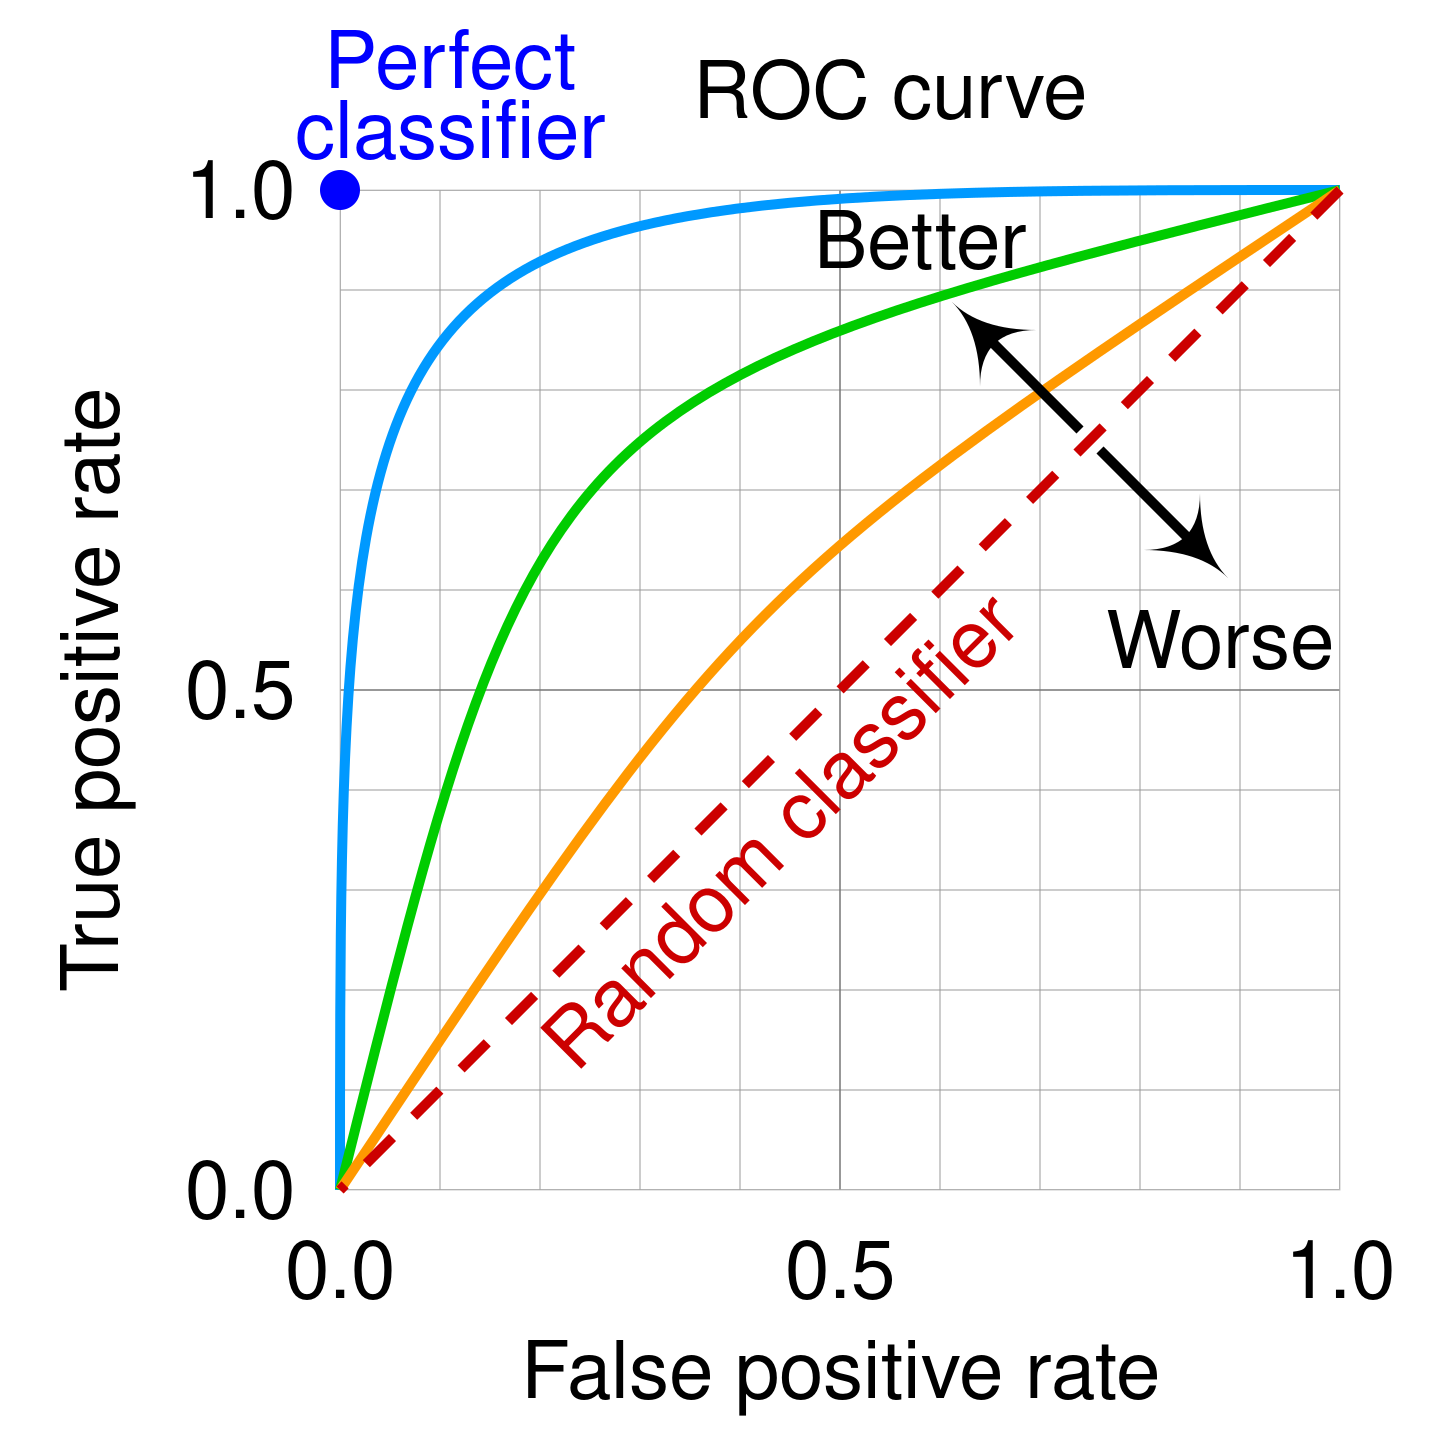
    
Each curve represents a model, where the curve shows how TPR and FPR at each threshold. The random model is a line $y=x$ because it will be (on average) predicting the same TPR as FPR.

However it is sometimes difficult to observe for which model the ROC curve gives best results, to get this info we find the area under the curve. (since a perfect model would have an area of 1). 
    
**This method should be used if we care only about ranking predictions and not about giving the probabilities.
 However there has been research [Takaya, Marc], indicating that if the class is skewed (i.e. positives>>negatives) this is not the best method.**
    <li>PR AUC</li>
This is similar to ROC AUC, but instead we use a Precision-Recall curve. I think of it as an alternative to ROC AUC **when the class is heavily skewed. This is also great when we want to decide which threshold to use.**
    
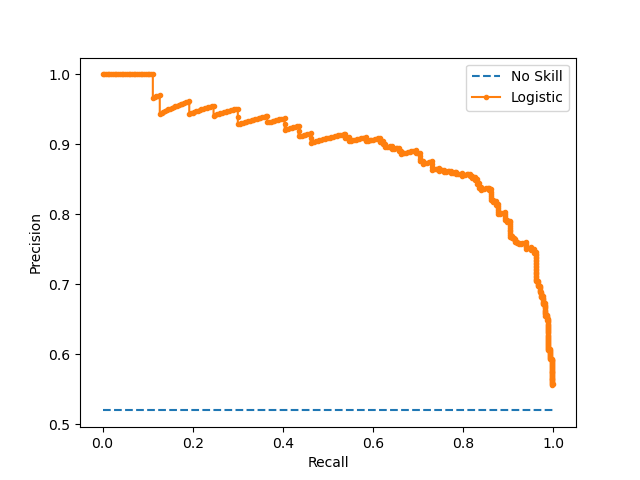
<ol>

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score